# Proyecto Final - Asignatura Modelos Predictivos
# Sharon Garcia

### Importar Librerias

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # single exponential smoothing 
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error,r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tabulate import tabulate
from prophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

### Tranformaciones Iniciales

In [142]:
df=pd.read_csv("train.csv")
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [114]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [143]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y') #transformar Order date a tipo fecha
df=df.sort_values(by='Order Date', ascending=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y') #transformar Ship date a tipo fecha
df.info()
df_copy = df[['Order Date', 'Sales']].copy()

<class 'pandas.core.frame.DataFrame'>
Index: 9800 entries, 7980 to 5091
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 non

In [144]:
#Creacionnde columnas de mes, dia, semana y ano en base a la fecha de orden
df['OrderDatePeriodDay'] = df['Order Date'].dt.to_period("D")
df['OrderDatePeriodMonth'] = df['Order Date'].dt.to_period("M")
df['OrderDatePeriodYear'] = df['Order Date'].dt.to_period("Y")
df['OrderDatePeriodWeek'] = df['Order Date'].dt.to_period("W")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9800 entries, 7980 to 5091
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Row ID                9800 non-null   int64         
 1   Order ID              9800 non-null   object        
 2   Order Date            9800 non-null   datetime64[ns]
 3   Ship Date             9800 non-null   datetime64[ns]
 4   Ship Mode             9800 non-null   object        
 5   Customer ID           9800 non-null   object        
 6   Customer Name         9800 non-null   object        
 7   Segment               9800 non-null   object        
 8   Country               9800 non-null   object        
 9   City                  9800 non-null   object        
 10  State                 9800 non-null   object        
 11  Postal Code           9789 non-null   float64       
 12  Region                9800 non-null   object        
 13  Product ID          

In [145]:
#Verificar los valores unicos dentro de las columnas country y region para confirmar si eliminarlas o mantenerlas
print(df['Country'].unique())
print(df['Region'].unique())

['United States']
['Central' 'East' 'South' 'West']


In [119]:
#Eliminar columnas no utiles para el analisis
df = df.drop(columns=['Row ID','Customer Name','Country','City','State','Postal Code','Product Name','Sub-Category'])

In [120]:
#Crear una columna que calcule los dias que demora en hacer el delivery
df["Delivery Days"]=df['Ship Date']-df['Order Date']
df['Delivery Days']=df['Delivery Days'].dt.days

In [121]:
#Analisis las estadisticas descriptivas de las variable continuas o discretas
df.describe()

,Order Date,Ship Date,Sales,Delivery Days
count,9800,9800,9800.000000,9800.000000
mean,2017-05-01 05:13:51.673469440,2017-05-05 04:17:52.653061120,230.769059,3.961122
min,2015-01-03 00:00:00,2015-01-07 00:00:00,0.444000,0.000000
25%,2016-05-24 00:00:00,2016-05-27 18:00:00,17.248000,3.000000
50%,2017-06-26 00:00:00,2017-06-29 00:00:00,54.490000,4.000000
75%,2018-05-15 00:00:00,2018-05-19 00:00:00,210.605000,5.000000
max,2018-12-30 00:00:00,2019-01-05 00:00:00,22638.480000,7.000000
std,NaN,NaN,626.651875,1.749614


In [122]:
#Imprimir las primeras cinco filas del dataset
df.head(5)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Region,Product ID,Category,Sales,OrderDatePeriodDay,OrderDatePeriodMonth,OrderDatePeriodYear,OrderDatePeriodWeek,Delivery Days
7980,CA-2015-103800,2015-01-03,2015-01-07,Standard Class,DP-13000,Consumer,Central,OFF-PA-10000174,Office Supplies,16.448,2015-01-03,2015-01,2015,2014-12-29/2015-01-04,4
741,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Home Office,Central,OFF-BI-10004094,Office Supplies,3.540,2015-01-04,2015-01,2015,2014-12-29/2015-01-04,4
740,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Home Office,Central,OFF-ST-10002743,Office Supplies,272.736,2015-01-04,2015-01,2015,2014-12-29/2015-01-04,4
739,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Home Office,Central,OFF-LA-10003223,Office Supplies,11.784,2015-01-04,2015-01,2015,2014-12-29/2015-01-04,4
1759,CA-2015-141817,2015-01-05,2015-01-12,Standard Class,MB-18085,Consumer,East,OFF-AR-10003478,Office Supplies,19.536,2015-01-05,2015-01,2015,2015-01-05/2015-01-11,7


### EDA

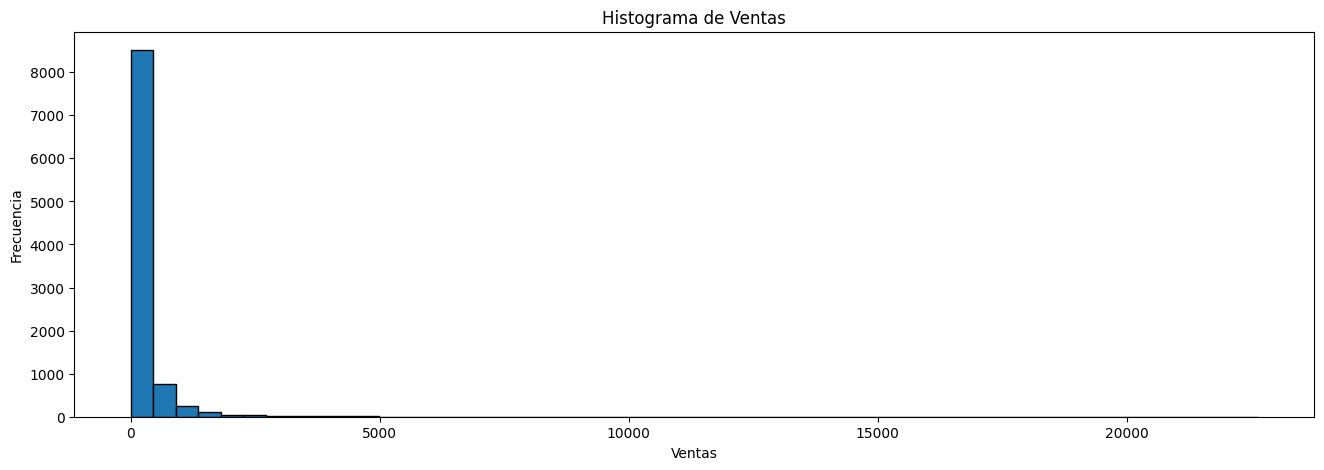

In [123]:
# Crear el histograma de la columna 'Sales'
plt.hist(df['Sales'], bins=50, edgecolor='black')
plt.title('Histograma de Ventas')
plt.xlabel('Ventas')
plt.ylabel('Frecuencia')
plt.show()

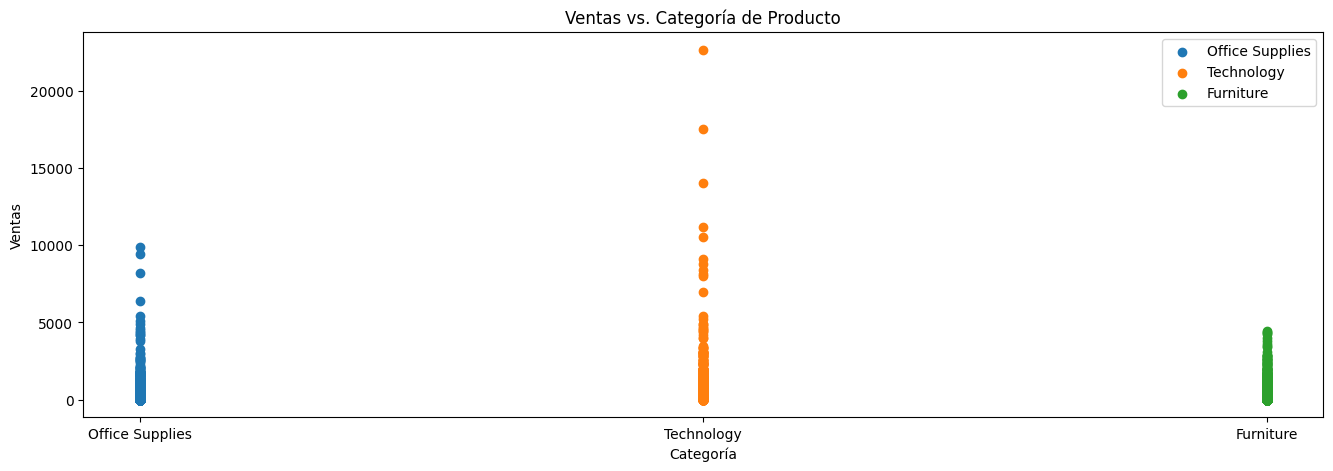

In [124]:
#Grafico de dispercion de Ventas totales vs categorias de producto

categorias = df['Category'].unique()
for categoria in categorias:
    subset = df[df['Category'] == categoria]
    plt.scatter(subset['Category'], subset['Sales'], label=categoria)

plt.title('Ventas vs. Categoría de Producto')
plt.xlabel('Categoría')
plt.ylabel('Ventas')
plt.legend()
plt.show()


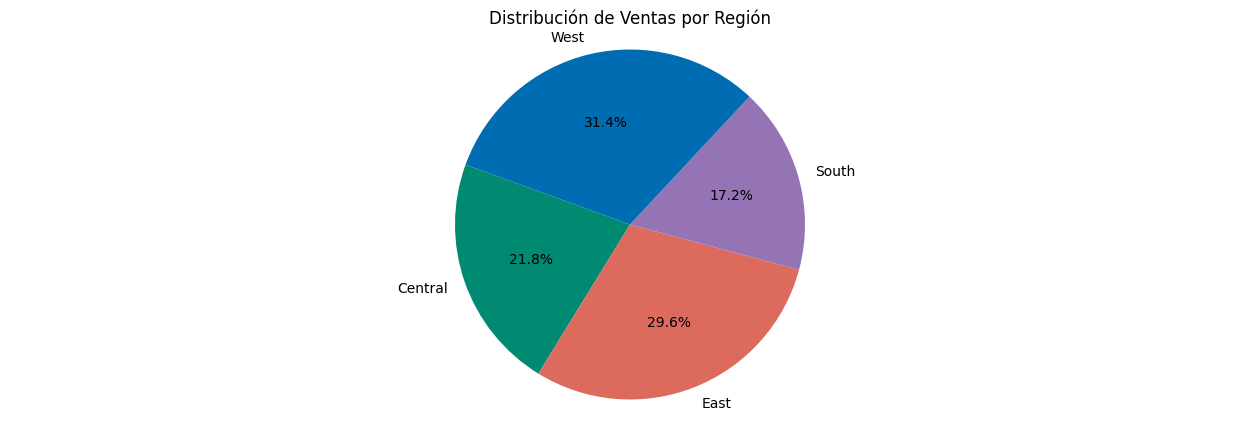

In [125]:
#Grafico pastel con la distribucion de Ventas por Region
store_sales = df.groupby('Region')['Sales'].sum().reset_index()

plt.pie(store_sales['Sales'], labels=store_sales['Region'], autopct='%1.1f%%', startangle=160, 
        colors=['#008a72', '#dc6a5d', '#9474b4', '#006cb2', '#4eace7'])

# Configurar el título y mostrar el gráfico
plt.title('Distribución de Ventas por Región')
plt.axis('equal')  # Asegurar que el gráfico es circular
plt.show()

##### La region con mas ventas es West con un 31.4%, seguido de East con 29.6%

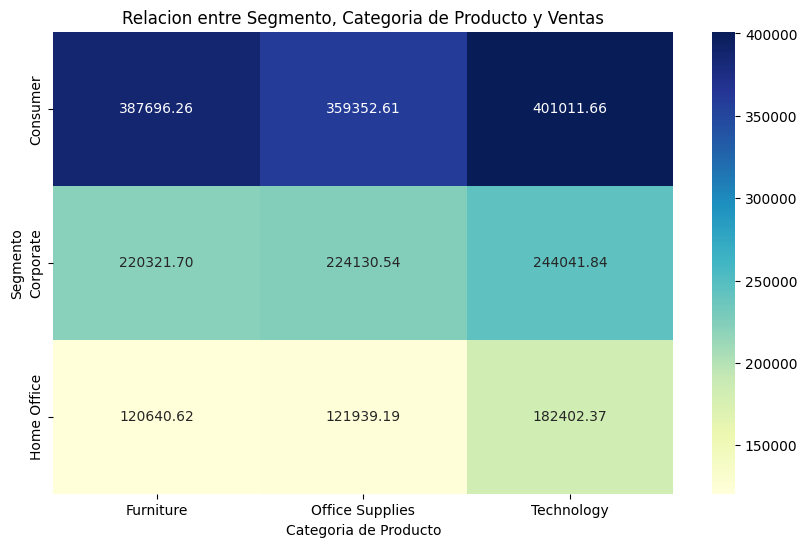

In [126]:
#Grafico tabla con la relacion entre las variables categoria de producto y segmento de clientes por ventas totales
grouped_data = df.groupby(['Segment', 'Category'])['Sales'].sum().reset_index()
pivot_df = grouped_data.pivot(index='Segment', columns='Category', values='Sales')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Relacion entre Segmento, Categoria de Producto y Ventas')
plt.xlabel('Categoria de Producto')
plt.ylabel('Segmento')
plt.show()

##### Se puede apreciar que la categoria de producto que mas ventas tiene es tecnologia con regular consumer siendo si segmento con ventas mas altas.

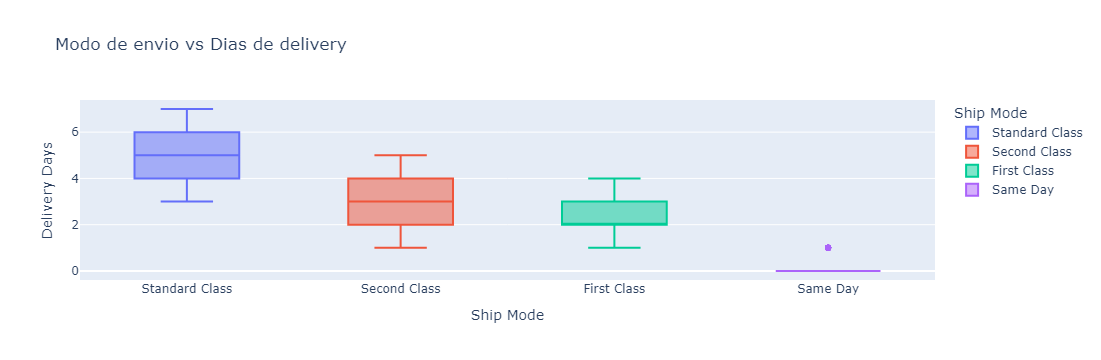

In [127]:
#Grafico de cajas que muestra el impacto de los dias de delivery con el modo de envio
box_fig = px.box(df, x='Ship Mode', y='Delivery Days', title='Modo de envio vs Dias de delivery',color='Ship Mode')

box_fig.show()

##### Para el modo standard el promedio son 5 dias, para Segunda clase el promedio son 3 dias y para primera clase el promedio son 2 dias.

### Analisis de Series Temporales en base al Order Date

In [128]:
#Creacion de un dataset para agrupar las ventas por Año-Mes de fecha de envio
dfw=df[['OrderDatePeriodMonth','Sales']].groupby('OrderDatePeriodMonth').sum()
dfw_forecast = dfw
dfw.index

PeriodIndex(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
             '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
             '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
             '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
             '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12'],
            dtype='period[M]', name='OrderDatePeriodMonth')

<Axes: title={'center': 'Ventas totales por Mes y Año'}, xlabel='Order Date'>

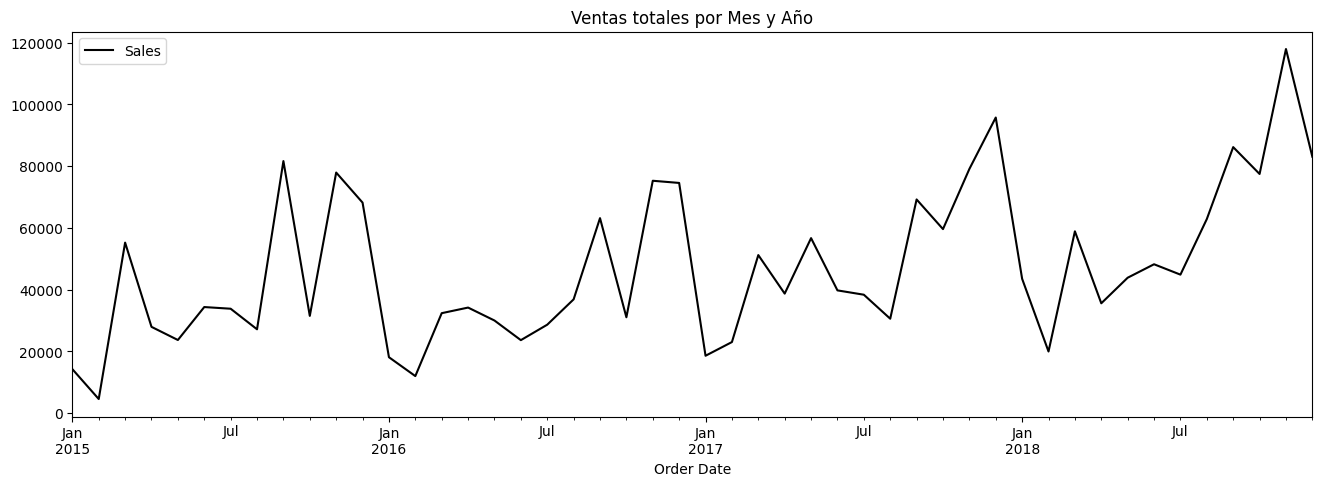

In [129]:
#Grafico de Ventas totales por MesAño
dfw.plot(kind='line',y='Sales',xlabel='Order Date',title="Ventas totales por Mes y Año",figsize=(16,5),color = "black")

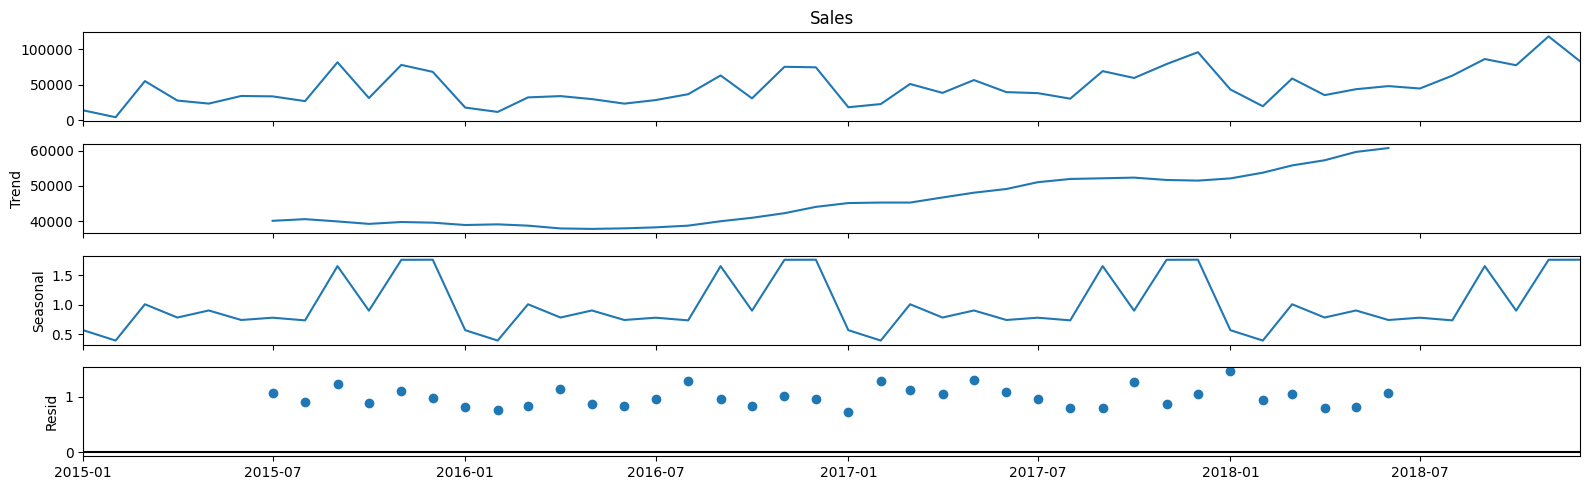

In [130]:
# Se realiza una descomposición estacional de la serie temporal de ventas utilizando un modelo multiplicativo
df_decompose = dfw
df_decompose.index = df_decompose.index.to_timestamp()
decompose_result = seasonal_decompose(df_decompose['Sales'],model='multiplicative')
decompose_result.plot()
plt.show()

##### Se puede apreciar que cumple con los 3 nivels, es estacional y tiene tendencia.

#### Modelo de Winter

In [131]:
dfw.index.freq = 'MS'
m = 12
alpha = 1/(2*m) #se pone de esta manera para tener en consideracion la estacionalidad

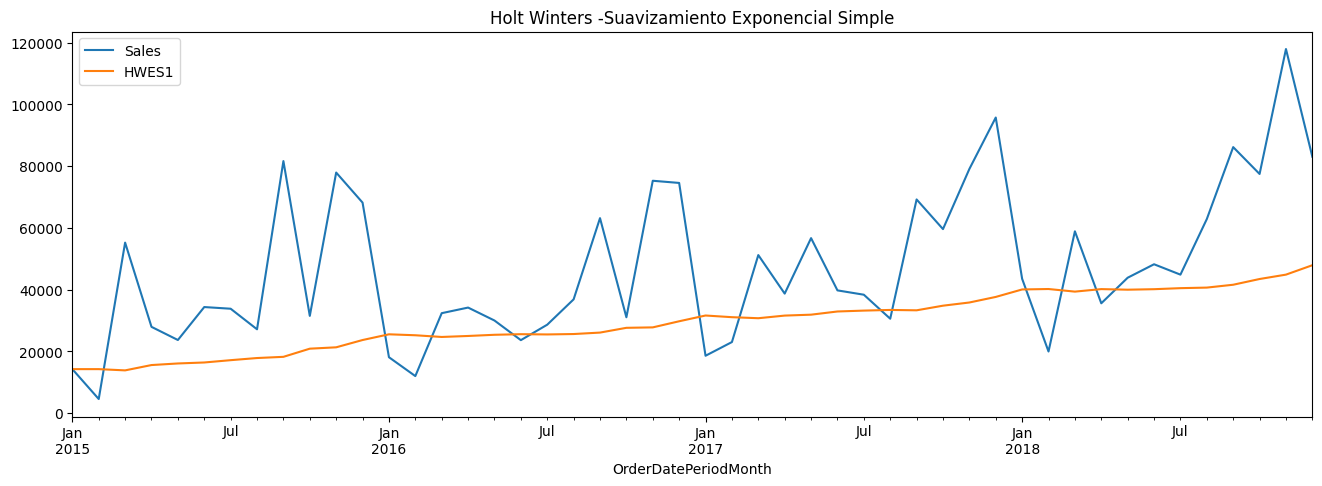

In [132]:
#Suavizamiento exponencial simple
dfw['HWES1'] = SimpleExpSmoothing(dfw['Sales']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
dfw[['Sales','HWES1']].plot(title='Holt Winters -Suavizamiento Exponencial Simple');

##### Como era de esperar el Suavizamiento exponencial simple no se ajusto de manera correcta, ya que este modelo no funciona correctamente con data con tendencia y estacionalidad 

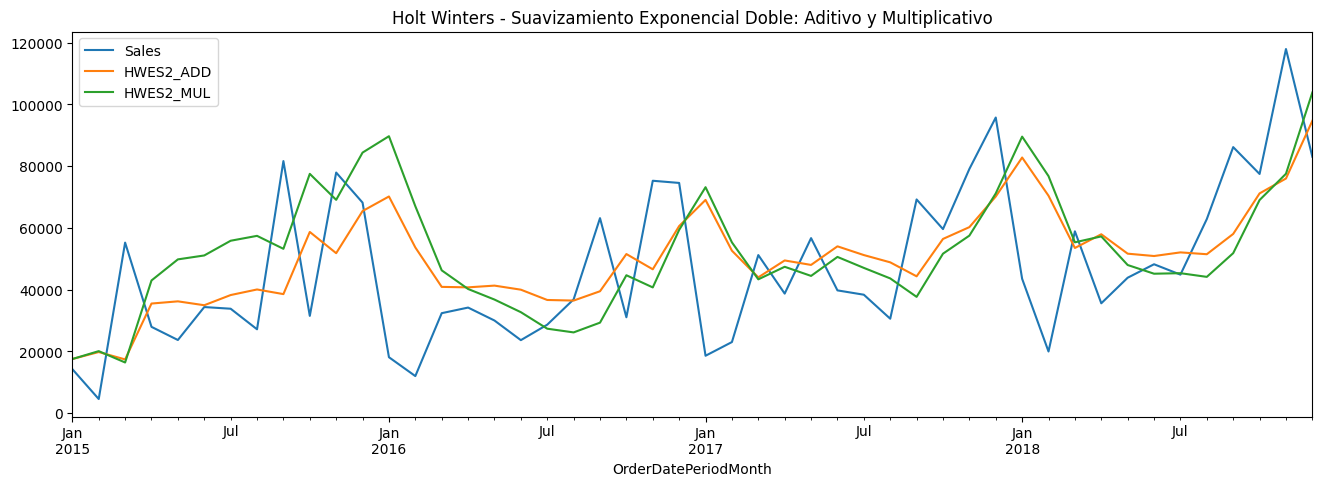

In [133]:
#Suavizamiento exponencial doble aditivo y multiplicativo
dfw['HWES2_ADD'] = ExponentialSmoothing(dfw['Sales'],trend='add').fit().fittedvalues
dfw['HWES2_MUL'] = ExponentialSmoothing(dfw['Sales'],trend='mul').fit().fittedvalues
dfw[['Sales','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters - Suavizamiento Exponencial Doble: Aditivo y Multiplicativo');

##### El suavizamiento exponencial doble se ajusta mejor al dataset pero como se conoce que existe estacionalidad se puede aplicar el Suavizamiento exponencial doble

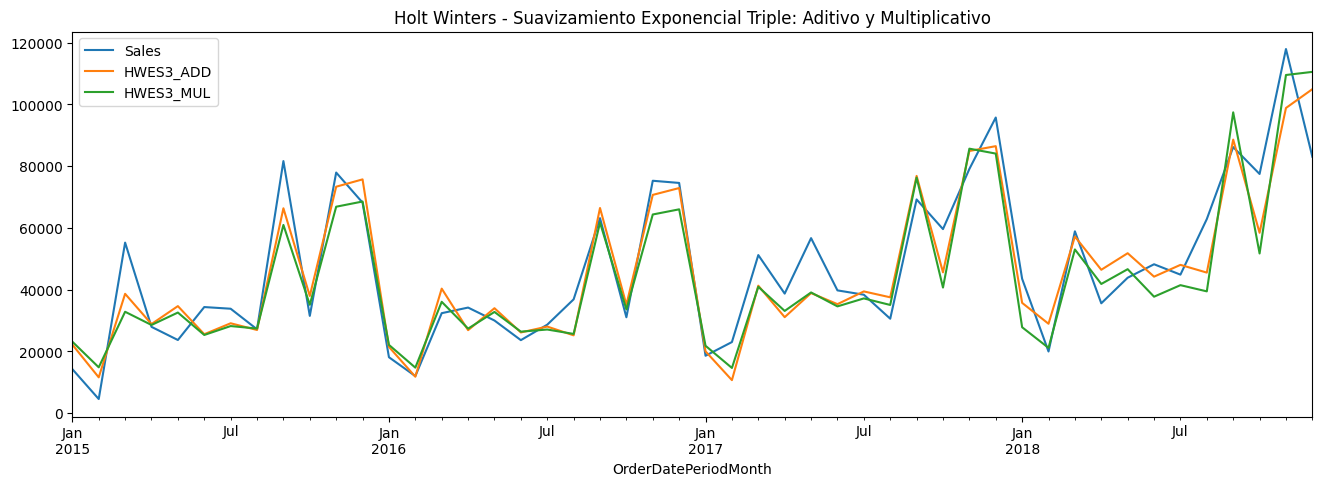

In [134]:
dfw['HWES3_ADD'] = ExponentialSmoothing(dfw['Sales'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
dfw['HWES3_MUL'] = ExponentialSmoothing(dfw['Sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
dfw[['Sales','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters - Suavizamiento Exponencial Triple: Aditivo y Multiplicativo');

##### El Suavisamiento exponencial triple se ajusta mucho mejor al modelo en su forma aditiva y multiplicativa capturando la estacionalidad

In [135]:
#Realizar un pronostico el modelo Holt Winter - Suavizamiento Exponencial Triple

dfw_forecast.index.freq = 'MS'
dfw_forecast = dfw_forecast.sort_index()

In [136]:
train_size = int(len(dfw_forecast) * 0.8)# Calcular el índice para dividir los datos

train_data = dfw_forecast[:train_size] #80% de los datos para entrenamiento
test_data  = dfw_forecast[train_size:] #20% de los datos para test


Text(0.5, 1.0, 'Valor Real vs Prediccion utilizando el Modelo Holt Winter')

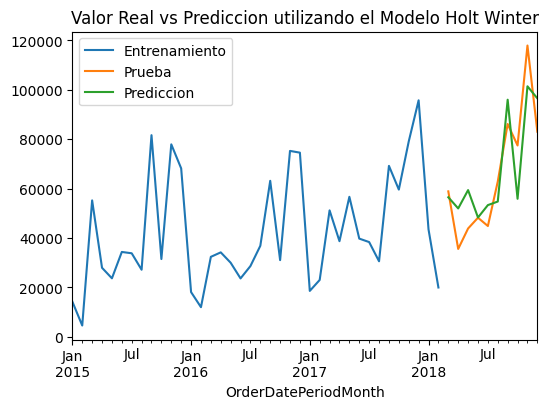

In [204]:
fitted_model = ExponentialSmoothing(train_data['Sales'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(10)
train_data['Sales'].plot(legend=True,label='Entrenamiento')

test_data['Sales'].plot(legend=True,label='Prueba',figsize=(6,4))
test_predictions.plot(legend=True,label='Prediccion')
plt.title('Valor Real vs Prediccion utilizando el Modelo Holt Winter')

<Axes: xlabel='OrderDatePeriodMonth'>

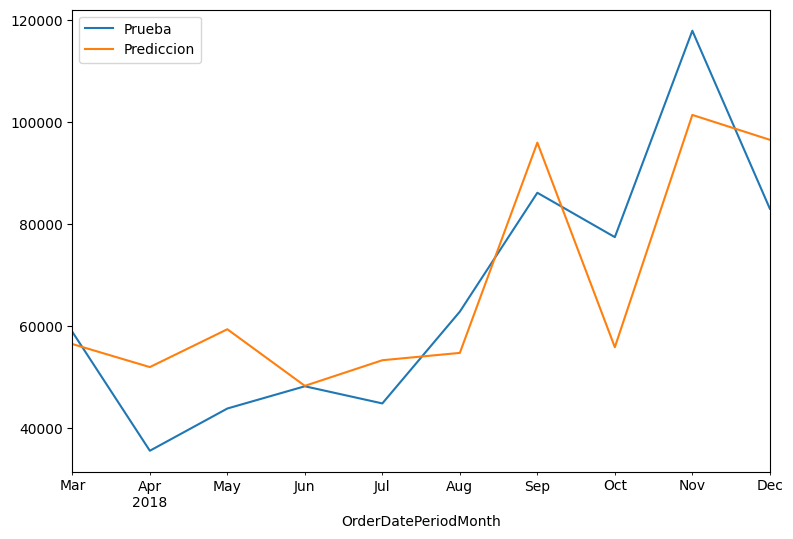

In [205]:
#Grafico de Comparacion de data de Prueba y prediccion
test_data['Sales'].plot(legend=True,label='Prueba',figsize=(9,6))
test_predictions.plot(legend=True,label='Prediccion')

In [206]:
print(test_predictions)

2018-03-01     56475.410127
2018-04-01     51952.960058
2018-05-01     59375.110275
2018-06-01     48274.990652
2018-07-01     53298.261399
2018-08-01     54737.742702
2018-09-01     95990.099044
2018-10-01     55849.252628
2018-11-01    101422.384657
2018-12-01     96543.407388
Freq: MS, dtype: float64


In [207]:
#Calculo de Metricas de Evaluacion del Modelo
mae_w = mean_absolute_error(test_data['Sales'],test_predictions)
mse_w = mean_squared_error(test_data['Sales'],test_predictions)
mad_w = test_data['Sales'].sub(test_predictions).abs().mean()
mape_w = (test_data['Sales'].sub(test_predictions).abs() / test_data['Sales']).mean() * 100

ts_w = mae_w / mad_w
ts_min_w = min(ts_w, 0)
ts_max_w = max(ts_w, 0)

r2_w = r2_score(test_data['Sales'], test_predictions)

print(f'R^2 Score: {r2_w:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_w:.2f}%')
print(f'Mean Absolute Deviation (MAD): {mad_w:.2f}')
print(f'Mean Absolute Error = {mae_w:.2f}')
print(f'Mean Squared Error = {mse_w:.2f}')
print(f'TSmin: {ts_min_w}')
print(f'TSmax: {ts_max_w}')

R^2 Score: 0.71
Mean Absolute Percentage Error (MAPE): 18.73%
Mean Absolute Deviation (MAD): 11247.06
Mean Absolute Error = 11247.06
Mean Squared Error = 167286832.19
TSmin: 0
TSmax: 1.0


### MODELO SARIMAX

In [208]:
df_sales_per_date=df[['OrderDatePeriodMonth','Sales']].groupby('OrderDatePeriodMonth').sum()

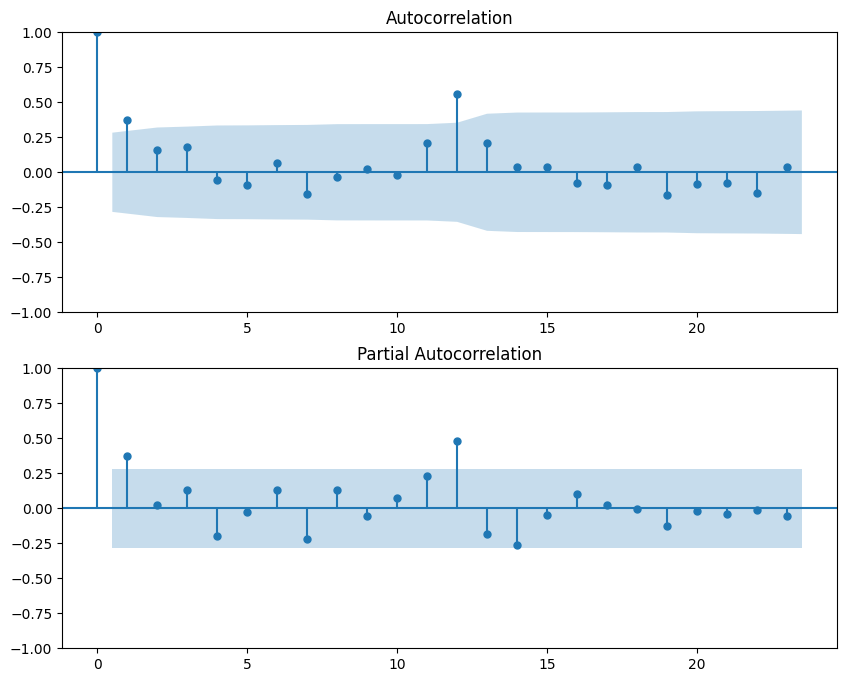

In [209]:
# Creacion de graficos ACF y PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_sales_per_date, lags=23, ax=ax1)
plot_pacf(df_sales_per_date, lags=23, ax=ax2)

plt.show()

In [210]:
from pmdarima import auto_arima
time_sales = df_copy.groupby("Order Date").sum()
time_sales.reset_index(inplace=True)
sale_monthly = time_sales.resample('M', on='Order Date').mean()
model_param = auto_arima(sale_monthly, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=778.118, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=751.400, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=776.240, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=769.567, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=749.819, Time=0.52 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=751.442, Time=0.73 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=749.384, Time=0.45 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=760.387, Time=0.15 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=751.400, Time=0.74 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=756.210, Time=0.53 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=760.050, Time=0.23 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=74

In [211]:
#Creacion de dataset para Entrenamiento y Prueba
df_train = df_sales_per_date[df_sales_per_date.index <= pd.to_datetime("2018-07-01", format='%Y-%m-%d').to_period("M")]
df_test = df_sales_per_date[df_sales_per_date.index >= pd.to_datetime("2018-07-01", format='%Y-%m-%d').to_period("M")]

In [212]:
#Setear el index como timestamp
df_train.index = df_train.index.to_timestamp()
df_test.index = df_test.index.to_timestamp()

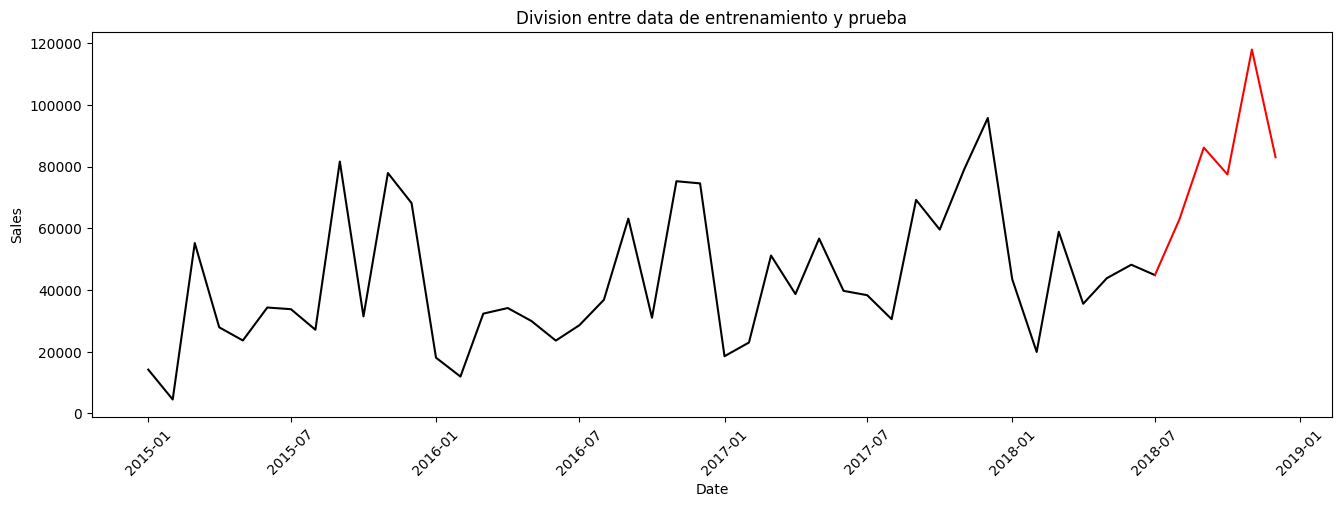

In [213]:
#Grafico que muestra la divisionentre la data de entrenamiento con la data de Prueba
plt.plot(df_train, color = "black")
plt.plot(df_test, color = "red")
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Division entre data de entrenamiento y prueba")
plt.rcParams["figure.figsize"] = (16,5)
plt.show()

In [214]:
#setear la data de entrenamiento
y=df_train['Sales']

In [215]:
#Definir la estacionalidad del modelo sarimax
SARIMAXmodel = SARIMAX(y, seasonal_order=(1,2,2,12))

In [216]:
#Entrenar el modelo
SARIMAXmodel = SARIMAXmodel.fit()

In [217]:
#Hacer las predicciones
y_pred = SARIMAXmodel.get_forecast(len(df_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df["Predictions"]

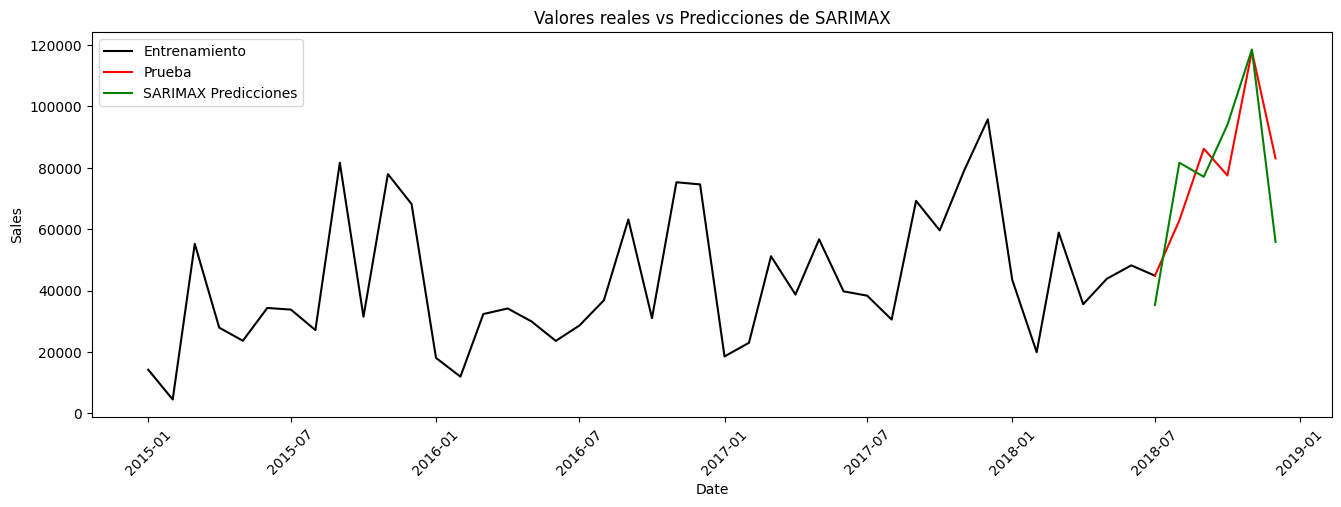

In [218]:
#Graficar las predicciones junto a los valores reales
plt.plot(df_train, color = 'black', label = 'Entrenamiento')
plt.plot(df_test, color = 'red',label='Prueba')
plt.plot(y_pred_out, color='green', label = 'SARIMAX Predicciones')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Valores reales vs Predicciones de SARIMAX")
plt.rcParams["figure.figsize"] = (16,5)
plt.legend()
plt.show()

In [219]:
#Calculo de Metricas de Evaluacion del Modelo
mae_sar = mean_absolute_error(df_test['Sales'],y_pred_out)
mse_sar = mean_squared_error(df_test['Sales'],y_pred_out)
mad_sar = df_test['Sales'].sub(y_pred_out).abs().mean()
mape_sar = (df_test['Sales'].sub(y_pred_out).abs() / df_test['Sales']).mean() * 100

ts_sar = mae_sar / mad_sar
ts_min_sar = min(ts_w, 0)
ts_max_sar = max(ts_w, 0)

r2_sar = r2_score(df_test['Sales'], y_pred_out)

print(f'R^2 Score: {r2_sar:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_sar:.2f}%')
print(f'Mean Absolute Deviation (MAD): {mad_sar:.2f}')
print(f'Mean Absolute Error = {mae_sar:.2f}')
print(f'Mean Squared Error = {mse_sar:.2f}')
print(f'TSmin: {ts_min_sar}')
print(f'TSmax: {ts_max_sar}')

R^2 Score: 0.49
Mean Absolute Percentage Error (MAPE): 19.39%
Mean Absolute Deviation (MAD): 13625.25
Mean Absolute Error = 13625.25
Mean Squared Error = 257059195.56
TSmin: 0
TSmax: 1.0


In [220]:
print(SARIMAXmodel.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   Sales   No. Observations:                   43
Model:             SARIMAX(1, 0, 0)x(1, 2, [1, 2], 12)   Log Likelihood                -209.964
Date:                                 Tue, 18 Jun 2024   AIC                            429.928
Time:                                         17:35:59   BIC                            434.650
Sample:                                     01-01-2015   HQIC                           430.727
                                          - 07-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0199      0.671      0.030      0.976      -1.295       1

Fold 1:
MSE del fold: 1358923789.47
MAD del fold (aproximado): 29412.88

Fold 2:
MSE del fold: 145146342.50
MAD del fold (aproximado): 9612.65

Fold 3:
MSE del fold: 282382173.66
MAD del fold (aproximado): 13407.84

Fold 4:
MSE del fold: 342926280.44
MAD del fold (aproximado): 14775.44

Fold 5:
MSE del fold: 532189394.66
MAD del fold (aproximado): 18406.58



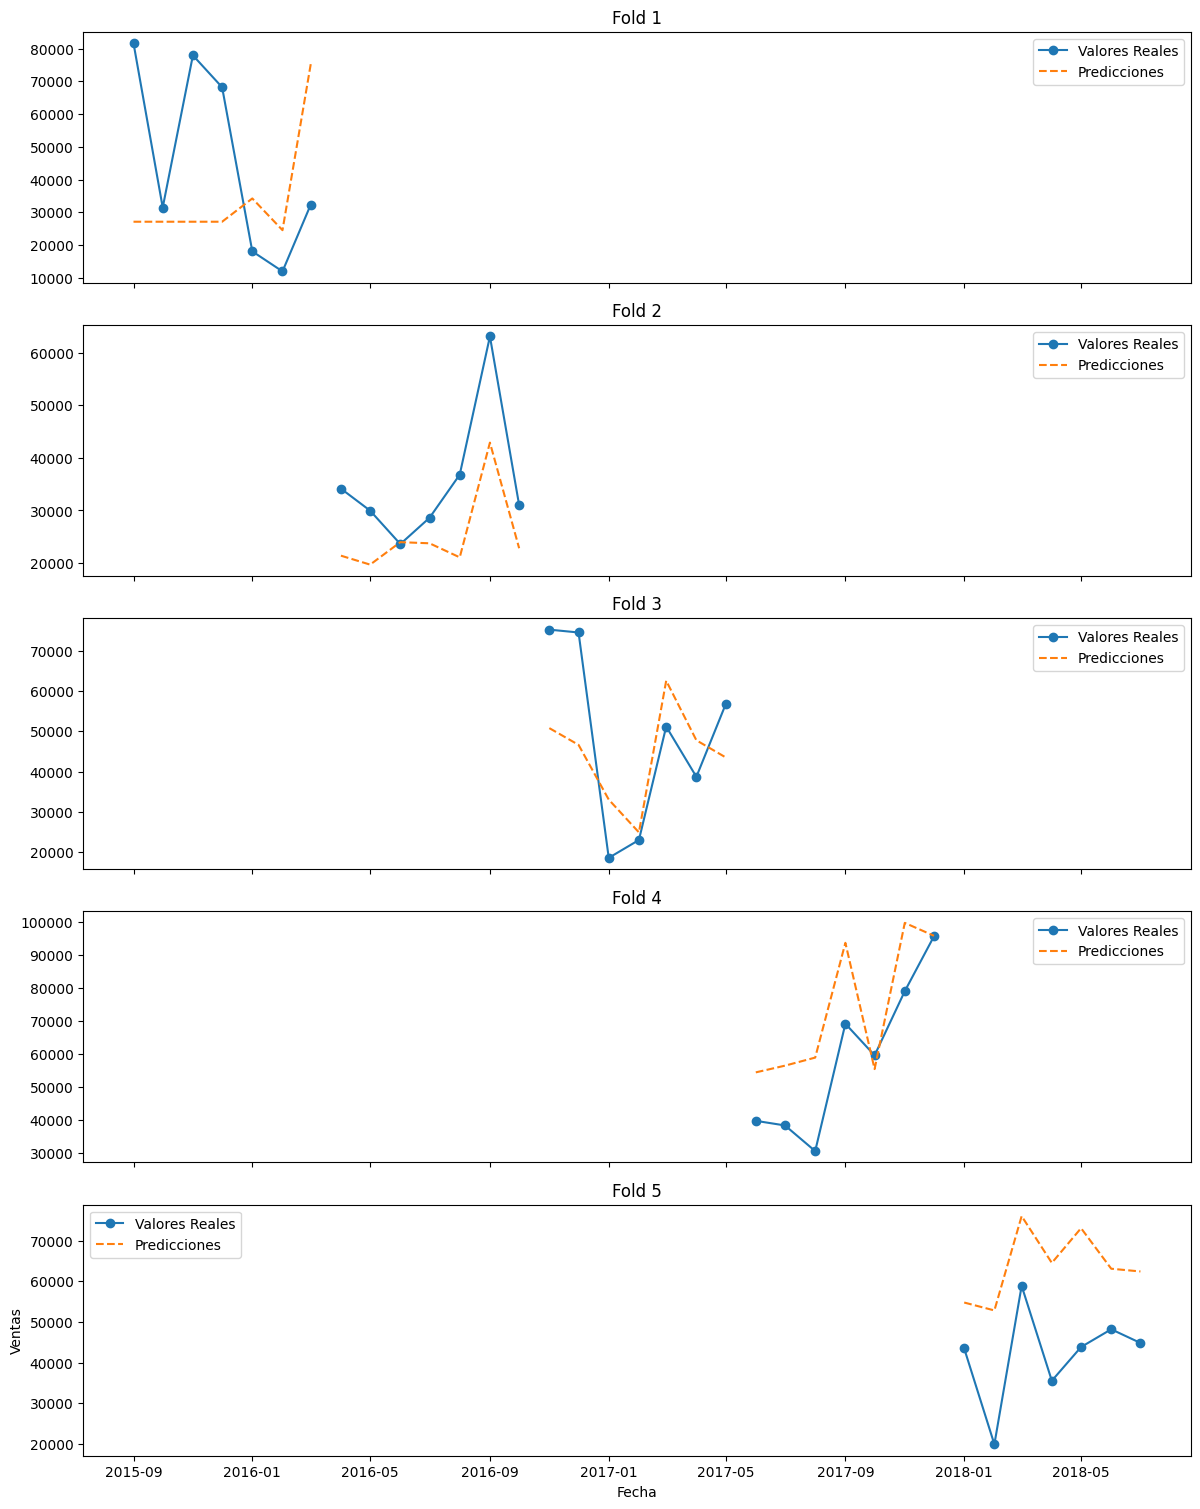

MSE promedio de validación cruzada: 532313596.14
Desviación estándar del MSE: 431628585.88
MAD promedio de validación cruzada (aproximado): 17123.08
Desviación estándar del MAD (aproximado): 6758.81


In [221]:
#Realizar validacion cruzada
tscv = TimeSeriesSplit(n_splits=5)  # Dividir en 5 splits

mse_scores = []  # Lista para almacenar los MSE de cada fold
mad_scores = []  # Lista para almacenar los MAD de cada fold

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)

for i, (train_index, test_index) in enumerate(tscv.split(y)):
    # Dividir los datos en entrenamiento y prueba para este fold
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Ajustar el modelo SARIMAX
    model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Ajusta los órdenes según tu modelo
    model_fit = model.fit()

    # Realizar predicciones
    y_pred = model_fit.forecast(steps=len(y_test))

    # Calcular el MSE para este fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calcular el MAD para este fold (como aproximación)
    mad_approx = np.sqrt(mse * 2 / np.pi)
    mad_scores.append(mad_approx)

    # Graficar las predicciones y valores reales
    axs[i].plot(y_test.index, y_test, label='Valores Reales', marker='o')
    axs[i].plot(y_test.index, y_pred, label='Predicciones', linestyle='--')
    axs[i].set_title(f'Fold {i+1}')
    axs[i].legend()

    # Opcional: Imprimir resultados de cada fold
    print(f'Fold {i+1}:')
    print(f'MSE del fold: {mse:.2f}')
    print(f'MAD del fold (aproximado): {mad_approx:.2f}')
    print('')

plt.tight_layout()
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()

# Calcular el MSE promedio y desviación estándar de todos los folds
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

# Calcular el MAD promedio y desviación estándar de todos los folds
mean_mad = np.mean(mad_scores)
std_mad = np.std(mad_scores)

print(f'MSE promedio de validación cruzada: {mean_mse:.2f}')
print(f'Desviación estándar del MSE: {std_mse:.2f}')

print(f'MAD promedio de validación cruzada (aproximado): {mean_mad:.2f}')
print(f'Desviación estándar del MAD (aproximado): {std_mad:.2f}')



### Modelo Prophet

In [222]:
#creando una copia del dataset para agruparlos por mes y ventas
df2 = df
monthly_data = df.resample('M', on='Order Date')['Sales'].sum().reset_index()
monthly_data = monthly_data.rename(columns={'Order Date': 'ds', 'Sales': 'y'}) 
#Prophet espera que las fechas de entrada estén en una columna llamada ds y los valores a predecir estén en una columna llamada y.

In [223]:
# Inicializar y ajustar el modelo
model = Prophet()
model.fit(monthly_data)

17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing


In [224]:
# Realiza predicciones futuras de los proximos 12 meses
future = model.make_future_dataframe(periods=12, freq='M') #crea df de predicciones futuras
forecast = model.predict(future) #predice

actual_data = monthly_data['y']
fitted_data = forecast['yhat'][:len(monthly_data)]  # valores ajustados para los datos historicos
forecast_data = forecast['yhat'][len(monthly_data):] #Predicciones del proximo ano


In [225]:
#Calculo de Metricas de Evaluacion del Modelo
mae_p = mean_absolute_error(actual_data,fitted_data)
mse_p = mean_squared_error(actual_data,fitted_data)
mad_p = actual_data.sub(fitted_data).abs().mean()
mape_p = (actual_data.sub(fitted_data).abs() / actual_data).mean() * 100

ts_p = mae_p / mad_p
ts_min_p = min(ts_p, 0)
ts_max_p = max(ts_p, 0)

r2_p = r2_score(actual_data, fitted_data)
print(f'R^2 Score: {r2_p:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_p:.2f}%')
print(f'Mean Absolute Deviation (MAD): {mad_p:.2f}')
print(f'Mean Absolute Error = {mae_p:.2f}')
print(f'Mean Squared Error = {mse_p:.2f}')
print(f'TSmin: {ts_min_p}')
print(f'TSmax: {ts_max_p}')

R^2 Score: 0.91
Mean Absolute Percentage Error (MAPE): 14.48%
Mean Absolute Deviation (MAD): 5770.41
Mean Absolute Error = 5770.41
Mean Squared Error = 52882034.68
TSmin: 0
TSmax: 1.0


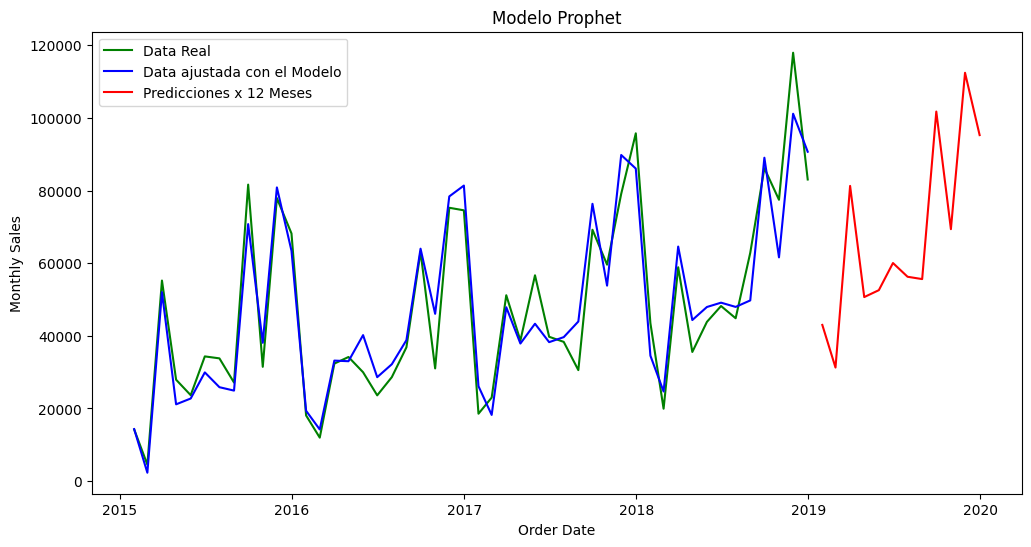

In [226]:
# Plot the actual data, fitted data, and forecast for the next 12 months
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['ds'], actual_data, label='Data Real', color='green')
plt.plot(monthly_data['ds'], fitted_data, label='Data ajustada con el Modelo', color='blue')
plt.plot(forecast['ds'][len(monthly_data):], forecast_data, label='Predicciones x 12 Meses', color='red')

plt.legend()
plt.xlabel('Order Date')
plt.ylabel('Monthly Sales')
plt.title('Modelo Prophet')
plt.show()


In [227]:
# Crear un DataFrame con las métricas
metrics_dict = {
    'Modelo': ['Prophet', 'SARIMAX', 'Holt Winter'],
    'MSE': [mse_p, mse_sar,mse_w],
    'MAD': [mad_p, mad_sar,mad_w],
    'MAPE': [mape_p, mape_sar,mape_w],
    'R2': [r2_p, r2_sar,r2_w],
    'STD': [mad_p*1.25,mad_sar*1.25,mad_w*1.25]
}

metrics_df = pd.DataFrame(metrics_dict)

# Convertir el DataFrame a formato tabulado
table = tabulate(metrics_df, headers='keys', tablefmt='fancy_grid')

# Mostrar la tabla formateada
print(table)


╒════╤═════════════╤═════════════╤══════════╤═════════╤══════════╤══════════╕
│    │ Modelo      │         MSE │      MAD │    MAPE │       R2 │      STD │
╞════╪═════════════╪═════════════╪══════════╪═════════╪══════════╪══════════╡
│  0 │ Prophet     │ 5.2882e+07  │  5770.41 │ 14.4826 │ 0.913441 │  7213.01 │
├────┼─────────────┼─────────────┼──────────┼─────────┼──────────┼──────────┤
│  1 │ SARIMAX     │ 2.57059e+08 │ 13625.2  │ 19.3936 │ 0.488374 │ 17031.6  │
├────┼─────────────┼─────────────┼──────────┼─────────┼──────────┼──────────┤
│  2 │ Holt Winter │ 1.67287e+08 │ 11247.1  │ 18.7263 │ 0.710099 │ 14058.8  │
╘════╧═════════════╧═════════════╧══════════╧═════════╧══════════╧══════════╛
